In [12]:
import torch
import math
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
import scipy.stats
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from nn_resampler import nn_resampler

seed = 10000
torch.manual_seed(seed)
np.random.seed(seed)

load = False
save = True

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [13]:
# load gaussian data
train_data = np.load("data/train_data.npy")
train_edges = np.load("data/train_edges.npy")
test_data = np.load("data/test_data.npy")
test_edges = np.load("data/test_edges.npy")

In [14]:
# # load phase estimation data

good_phase_est_bins = np.load("data/good_bins.npy")
good_phase_est_edges = np.load("data/good_edges.npy")

bins_train, good_bins_val, edges_train, good_edges_val = train_test_split(
    good_phase_est_bins, good_phase_est_edges, test_size=0.001)

bins_train, bins_test, edges_train, edges_test = train_test_split(
    bins_train, edges_train, test_size=0.1)

train_data = np.append(train_data, bins_train, axis=0)
train_edges = np.append(train_edges, edges_train, axis=0)
test_data = np.append(test_data, bins_test, axis=0)
test_edges = np.append(test_edges, edges_test, axis=0)

In [15]:
poor_phase_est_bins = np.load("data/poor_bins.npy")
poor_phase_est_edges = np.load("data/poor_edges.npy")

bins_train, poor_bins_val, edges_train, poor_edges_val = train_test_split(
    good_phase_est_bins, good_phase_est_edges, test_size=0.001)

bins_train, bins_test, edges_train, edges_test = train_test_split(
    poor_phase_est_bins, poor_phase_est_edges, test_size=0.1)

train_data = np.append(train_data, bins_train, axis=0)
train_edges = np.append(train_edges, edges_train, axis=0)
test_data = np.append(test_data, bins_test, axis=0)
test_edges = np.append(test_edges, edges_test, axis=0)

In [16]:
train_data = train_data.astype(np.float32)
train_data = torch.from_numpy(train_data)
train_data = train_data.to(device)

test_data = test_data.astype(np.float32)
test_data = torch.from_numpy(test_data)
test_data = test_data.to(device)

In [17]:
good_bins_val = good_bins_val.astype(np.float32)
good_bins_val = torch.from_numpy(good_bins_val)
good_bins_val = good_bins_val.to(device)

poor_bins_val = poor_bins_val.astype(np.float32)
poor_bins_val = torch.from_numpy(poor_bins_val)
poor_bins_val = poor_bins_val.to(device)

In [18]:
train_dataset = torch.utils.data.TensorDataset(train_data)
train_data_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=512, shuffle=True)

In [19]:
epochs = 1000
net = nn_resampler(100,100)
net = net.to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=250, gamma=0.3)
loss_func = nn.KLDivLoss()
net.train();

In [20]:
if load is False:
    for e in range(epochs):
        train_loss_cum_sum = 0
        iters_per_epoch = 0
        for train_data_ in train_data_loader:
            train_data_ = train_data_[0].to(device)
            prediction = net(train_data_)
            loss = loss_func(torch.log(prediction), train_data_)
            train_loss = loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss_cum_sum += train_loss
            iters_per_epoch += 1
        

        if (e+1)%5 == 0:
            net.eval()
            test_pred = net(test_data)
            loss = loss_func(torch.log(test_pred), test_data)
            test_loss = loss.item()

            print("Epoch: {:d}, train loss: {:f}, test loss: {:f},"
                  .format(e, train_loss_cum_sum/iters_per_epoch, test_loss))
            net.train();
                
        scheduler.step()
        
    if save is True:
        torch.save(net.state_dict(), "model/nn_resampler.model")
else:
    net.load_state_dict(torch.load("model/nn_resampler.model"))

net.eval();

C:\Users\alvin\anaconda3\lib\site-packages\torch\nn\functional.py:2398: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


Epoch: 4, train loss: 0.003289, test loss: 0.003073,
Epoch: 9, train loss: 0.002697, test loss: 0.002570,
Epoch: 14, train loss: 0.002517, test loss: 0.002416,
Epoch: 19, train loss: 0.002407, test loss: 0.002310,
Epoch: 24, train loss: 0.002344, test loss: 0.002266,
Epoch: 29, train loss: 0.002286, test loss: 0.002206,
Epoch: 34, train loss: 0.002239, test loss: 0.002162,
Epoch: 39, train loss: 0.002199, test loss: 0.002121,
Epoch: 44, train loss: 0.002158, test loss: 0.002091,
Epoch: 49, train loss: 0.002132, test loss: 0.002058,
Epoch: 54, train loss: 0.002106, test loss: 0.002021,
Epoch: 59, train loss: 0.002080, test loss: 0.002002,
Epoch: 64, train loss: 0.002069, test loss: 0.001994,
Epoch: 69, train loss: 0.002049, test loss: 0.001969,
Epoch: 74, train loss: 0.002035, test loss: 0.001967,
Epoch: 79, train loss: 0.002023, test loss: 0.001973,
Epoch: 84, train loss: 0.002008, test loss: 0.001942,
Epoch: 89, train loss: 0.001988, test loss: 0.001931,
Epoch: 94, train loss: 0.00198

Epoch: 754, train loss: 0.001669, test loss: 0.001665,
Epoch: 759, train loss: 0.001670, test loss: 0.001666,
Epoch: 764, train loss: 0.001671, test loss: 0.001670,
Epoch: 769, train loss: 0.001671, test loss: 0.001664,
Epoch: 774, train loss: 0.001672, test loss: 0.001666,
Epoch: 779, train loss: 0.001672, test loss: 0.001667,
Epoch: 784, train loss: 0.001675, test loss: 0.001667,
Epoch: 789, train loss: 0.001670, test loss: 0.001668,
Epoch: 794, train loss: 0.001667, test loss: 0.001667,
Epoch: 799, train loss: 0.001669, test loss: 0.001666,
Epoch: 804, train loss: 0.001671, test loss: 0.001668,
Epoch: 809, train loss: 0.001668, test loss: 0.001668,
Epoch: 814, train loss: 0.001670, test loss: 0.001668,
Epoch: 819, train loss: 0.001667, test loss: 0.001666,
Epoch: 824, train loss: 0.001668, test loss: 0.001668,
Epoch: 829, train loss: 0.001666, test loss: 0.001664,
Epoch: 834, train loss: 0.001670, test loss: 0.001669,
Epoch: 839, train loss: 0.001667, test loss: 0.001668,
Epoch: 844

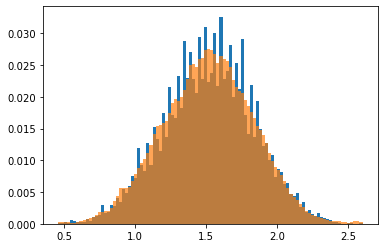

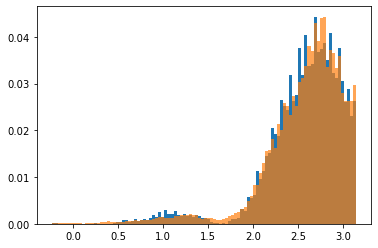

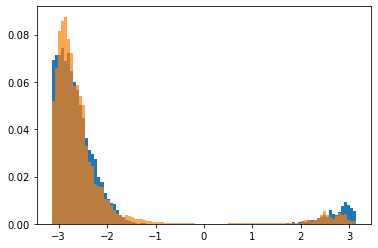

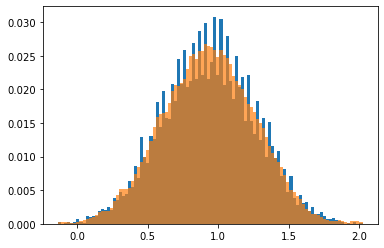

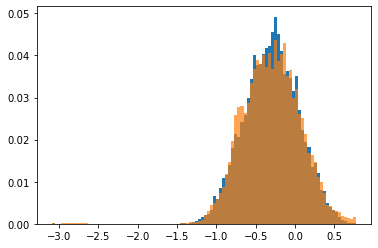

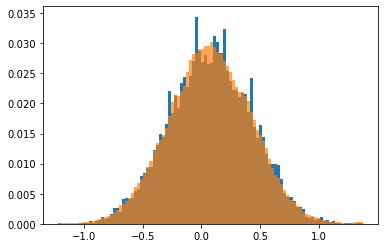

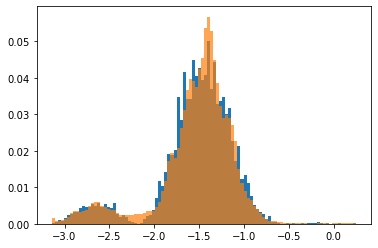

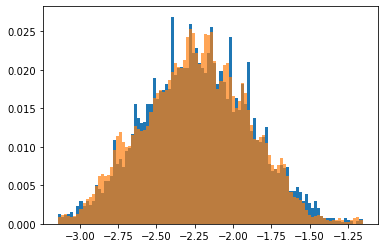

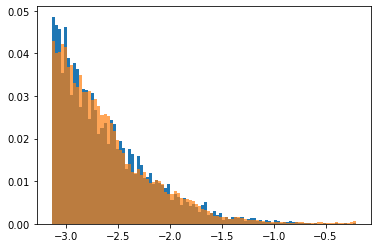

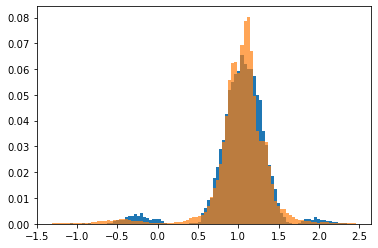

In [21]:
# test on poor phase estimation data
poor_test_pred = net(poor_bins_val)

for i in range(len(poor_test_pred)):
    test_edges = poor_edges_val[i]
    edge_width = test_edges[1] - test_edges[0]

    plt.bar(test_edges, poor_bins_val[i].cpu(), align='center', width = edge_width)
    plt.bar(test_edges, poor_test_pred[i].detach().cpu(), align='center', width = edge_width, alpha=0.7)
    plt.show() 
    

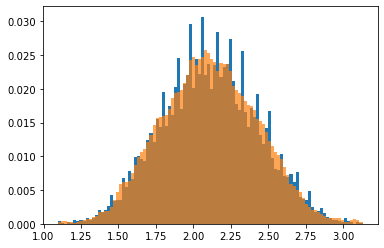

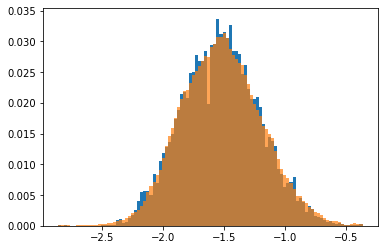

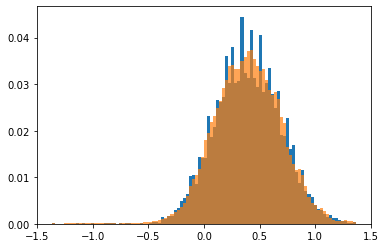

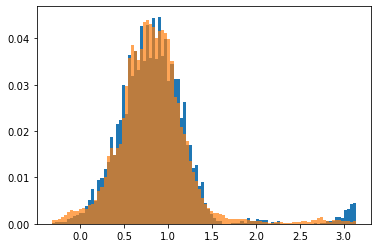

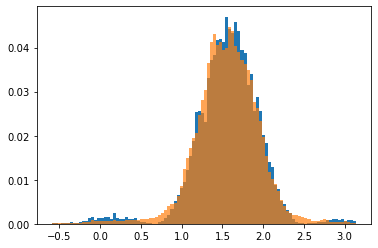

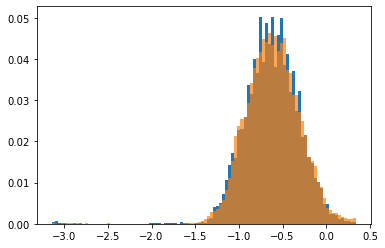

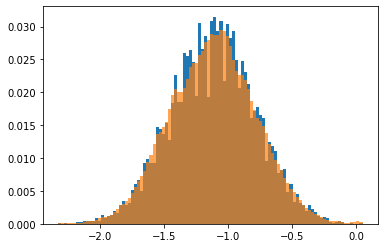

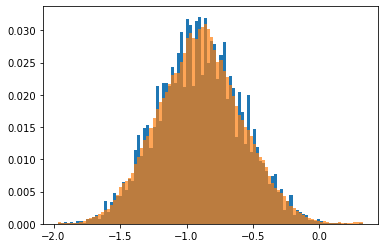

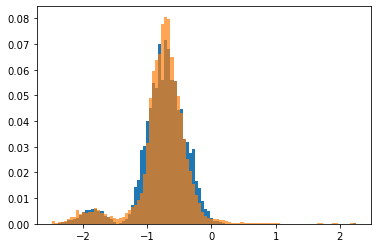

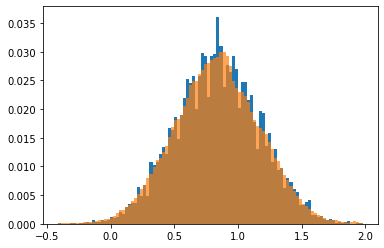

In [22]:
# test on good phase estimation data
good_test_pred = net(good_bins_val)

for i in range(len(poor_test_pred)):
    test_edges = good_edges_val[i]
    edge_width = test_edges[1] - test_edges[0]

    plt.bar(test_edges, good_bins_val[i].cpu(), align='center', width = edge_width)
    plt.bar(test_edges, good_test_pred[i].detach().cpu(), align='center', width = edge_width, alpha=0.7)
    plt.show() 
    